In [83]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import log_loss, make_scorer

In [192]:
from src.DataPreparation import fc, ffc

In [193]:
ffc.count_documents({})

1270

In [287]:
ffc.find()[0]

{'_id': ObjectId('5c098e3fbaead1a820a3cfcc'),
 'url': 'https://www.instagram.com/lirlando',
 'bio': '',
 'followed_by': 63,
 'follows': 76,
 'num_posts': 2,
 'id': '8882294111',
 'is_joined_recently': False,
 'is_private': False,
 'is_business_account': False,
 'likes_last_post': 10}

In [249]:
df = pd.DataFrame(list(ffc.find()))
df['bio'][1][21]

'😻'

In [195]:
df.shape

(1270, 11)

In [197]:
df['likes_last_post'].fillna(0, inplace = True)

In [198]:
df_dropped = df.dropna()

In [199]:
df_dropped.shape

(1195, 11)

In [200]:
df_dropped['is_business_account'] = df_dropped['is_business_account'].astype(int)
df_dropped['is_joined_recently'] = df_dropped['is_joined_recently'].astype(int)
df_dropped['is_private'] = df_dropped['is_private'].astype(int)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [201]:
df_dropped.shape

(1195, 11)

In [384]:
df_dropped[58:59]

,_id,bio,followed_by,follows,id,is_business_account,is_joined_recently,is_private,likes_last_post,num_posts,url
70,5c098e41baead1a820a3d0cb,,7220.0,77.0,1400576780,0,0,0,226.0,345.0,https://www.instagram.com/yuliagarciafer


In [205]:
(df_dropped['likes_last_post'] != 0).sum() # number of users have likes on last post

659

In [208]:
X = df_dropped.iloc[:,[2,3,6,7,8,9]]

In [209]:
X.shape

(1195, 6)

In [210]:
X.head()

,followed_by,follows,is_joined_recently,is_private,likes_last_post,num_posts
0,63.0,76.0,0,0,10.0,2.0
1,870.0,136.0,0,0,156.0,3.0
2,2100.0,700.0,0,0,26.0,180.0
3,14.0,48.0,1,0,0.0,0.0
6,306.0,441.0,0,1,0.0,21.0


In [211]:
y = df_dropped.iloc[:, 5]

In [212]:
y.head()

0    0
1    1
2    1
3    0
6    0
Name: is_business_account, dtype: int64

In [213]:
y.shape

(1195,)

### train-test split

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

In [215]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((896, 6), (299, 6), (896,), (299,))

### Logistic Regression

In [216]:
model_logistic = LogisticRegression()

In [217]:
model_logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [218]:
y_pred_logistic = model_logistic.predict_proba(X_test)[:,1]

In [219]:
log_loss_logistic = log_loss(y_test, y_pred_logistic)
log_loss_logistic

0.3750796596252087

In [220]:
cv_logloss = -cross_val_score(model_logistic, X, y, scoring = 'neg_log_loss', cv = 10).mean()
cv_logloss

0.3918929450268298

In [223]:
y_test_pred = pd.DataFrame({'actual':y_test,'prediction':y_pred_logistic})

# 'actual' == 0 means the account is actually not a business account, but y_pred high means 
# they are predicted to have high probability to be a business account
y_test_pred_filtered = y_test_pred[y_test_pred['actual']== 0]
y_test_pred_filtered[y_test_pred_filtered['prediction'] > 0.8]

,actual,prediction
841,0,0.818686


In [343]:
df_dropped.iloc[, :]

_id                               5c098e44baead1a820a3d41e
bio                                                       
followed_by                                            808
follows                                               1200
id                                              6994069838
is_business_account                                      1
is_joined_recently                                       0
is_private                                               0
likes_last_post                                         66
num_posts                                               23
url                    https://www.instagram.com/sicko.web
Name: 921, dtype: object

### First Random Forest 

In [225]:
rf = RandomForestClassifier(n_estimators=100,
                            n_jobs=-1,
                            random_state=1)

In [226]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [227]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]

In [228]:
log_loss_rf = log_loss(y_test, y_pred_rf)
log_loss_rf

0.47085412895713696

In [229]:
cv_logloss_rf1 = -cross_val_score(rf, X, y, cv = 10, scoring = 'neg_log_loss').mean()
cv_logloss_rf1

0.5359474913943488

In [336]:
y_test_pred1 = pd.DataFrame({'actual':y_test,'prediction':y_pred_rf})
y_test_pred_filtered1 = y_test_pred1[y_test_pred1['actual']== 0]
y_test_pred_filtered1[y_test_pred_filtered1['prediction'] > 0.8]

,actual,prediction
70,0,0.81
789,0,0.87


In [337]:
y_test_pred_filtered1.describe()

,actual,prediction
count,239.0,239.000000
mean,0.0,0.150377
std,0.0,0.228227
min,0.0,0.000000
25%,0.0,0.000000
50%,0.0,0.010000
75%,0.0,0.215000
max,0.0,0.870000


### Best Random Forest

In [232]:
random_forest_grid = {'max_depth': [3, 4, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [40, 80, 100, 120, 140, 160],
                      'random_state': [359]}

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='neg_log_loss')
rf_gridsearch.fit(X_train, y_train)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed:  4.6min finished


best parameters: {'bootstrap': False, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 40, 'random_state': 359}


In [233]:
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=3, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=359, verbose=0, warm_start=False)

In [422]:
y_pred_best = best_rf_model.predict_proba(X_test)[:, 1]

In [424]:
y_test_pred2 = pd.DataFrame({'actual':y_test,'prediction':y_pred_best})
y_test_pred_filtered2 = y_test_pred2[y_test_pred2['actual']== 0]
y_test_pred_filtered2[y_test_pred_filtered2['prediction'] > 0.6]

,actual,prediction
70,0,0.611954
427,0,0.611954


In [236]:
log_loss_rf = log_loss(y_test, y_pred_best)
log_loss_rf

0.3535236537162788

In [237]:
cv_logloss_rf2 = -cross_val_score(best_rf_model, X, y, cv = 10, scoring = 'neg_log_loss').mean()
cv_logloss_rf2

0.35749201794080243

### Model Evaluation

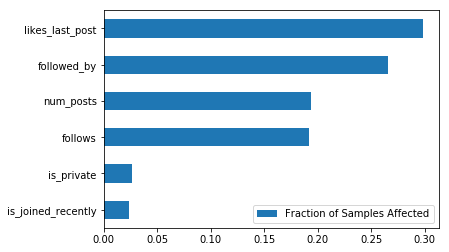

In [238]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh')

(array([153.,  15.,   8.,  15.,   4.,   3.,  24.,  17.]),
 array([0.01470985, 0.08936538, 0.16402091, 0.23867644, 0.31333197,
        0.3879875 , 0.46264303, 0.53729857, 0.6119541 ]),
 <a list of 8 Patch objects>)

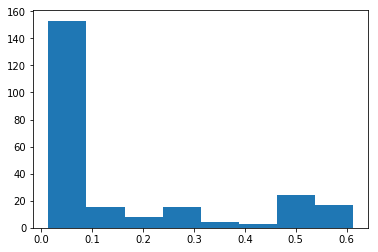

In [239]:
plt.hist(y_test_pred2[y_test_pred2['actual']== 0]['prediction'], bins = 8)

In [240]:
roc_auc_score(y_test, y_pred_best)

0.8498953974895397

In [241]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)

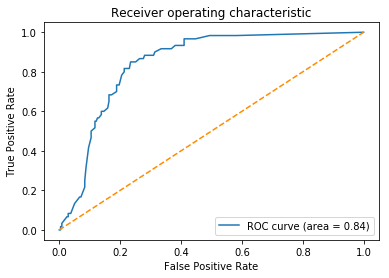

In [242]:
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_rf))
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [396]:
from src.DataPreparation import *

In [362]:
url = 'https://www.instagram.com/yuliagarciafer'

In [420]:
get_pred_one(url, best_rf_model)

array([0.6119541])

In [316]:
import pickle

In [317]:
# save the model to pickle
filename = 'finalized_model.sav'
pickle.dump(best_rf_model, open(filename, 'wb'))